In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

In [2]:
import yfinance as yf
df = yf.download('BTC-USD')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216
2023-12-23,44012.199219,44015.699219,43351.355469,43739.542969,43739.542969,13507796558
2023-12-24,43728.367188,43945.523438,42786.917969,43016.117188,43016.117188,18830554085


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216
2023-12-23,44012.199219,44015.699219,43351.355469,43739.542969,43739.542969,13507796558
2023-12-24,43728.367188,43945.523438,42786.917969,43016.117188,43016.117188,18830554085


In [4]:
df.isnull().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3388 entries, 2014-09-17 to 2023-12-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3388 non-null   float64
 1   High       3388 non-null   float64
 2   Low        3388 non-null   float64
 3   Close      3388 non-null   float64
 4   Adj Close  3388 non-null   float64
 5   Volume     3388 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.3 KB


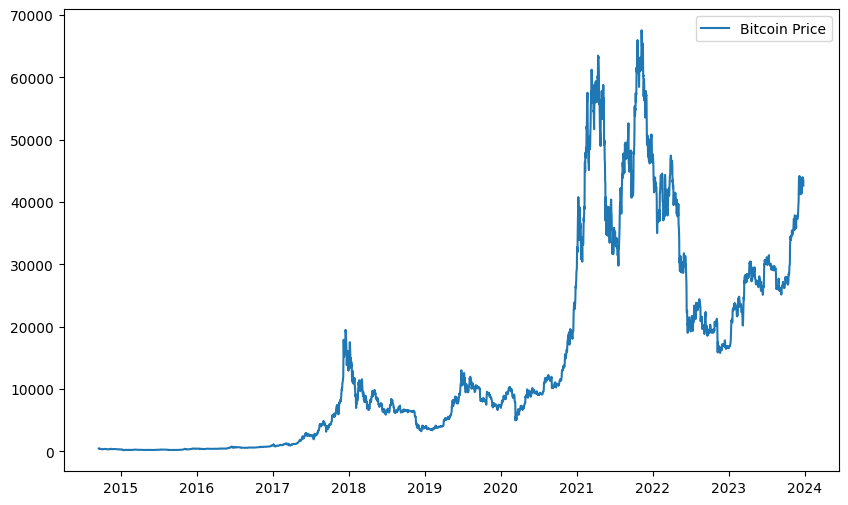

In [6]:
plt.figure(figsize=(10,6))
plt.plot(np.array(df.index),np.array(df['Close']) , label = "Bitcoin Price")
plt.legend()
plt.show()

<AxesSubplot:ylabel='Density'>

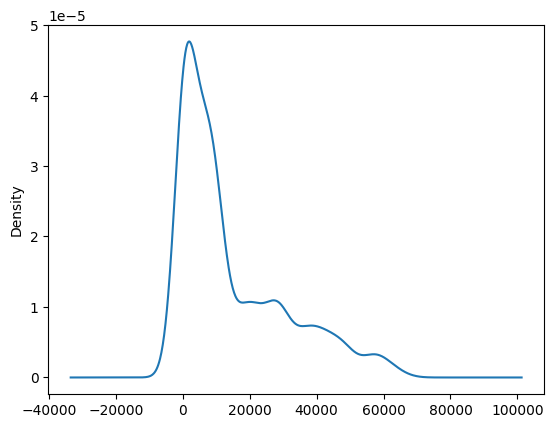

In [7]:
df['Close'].plot(kind='kde')

<Figure size 640x480 with 0 Axes>

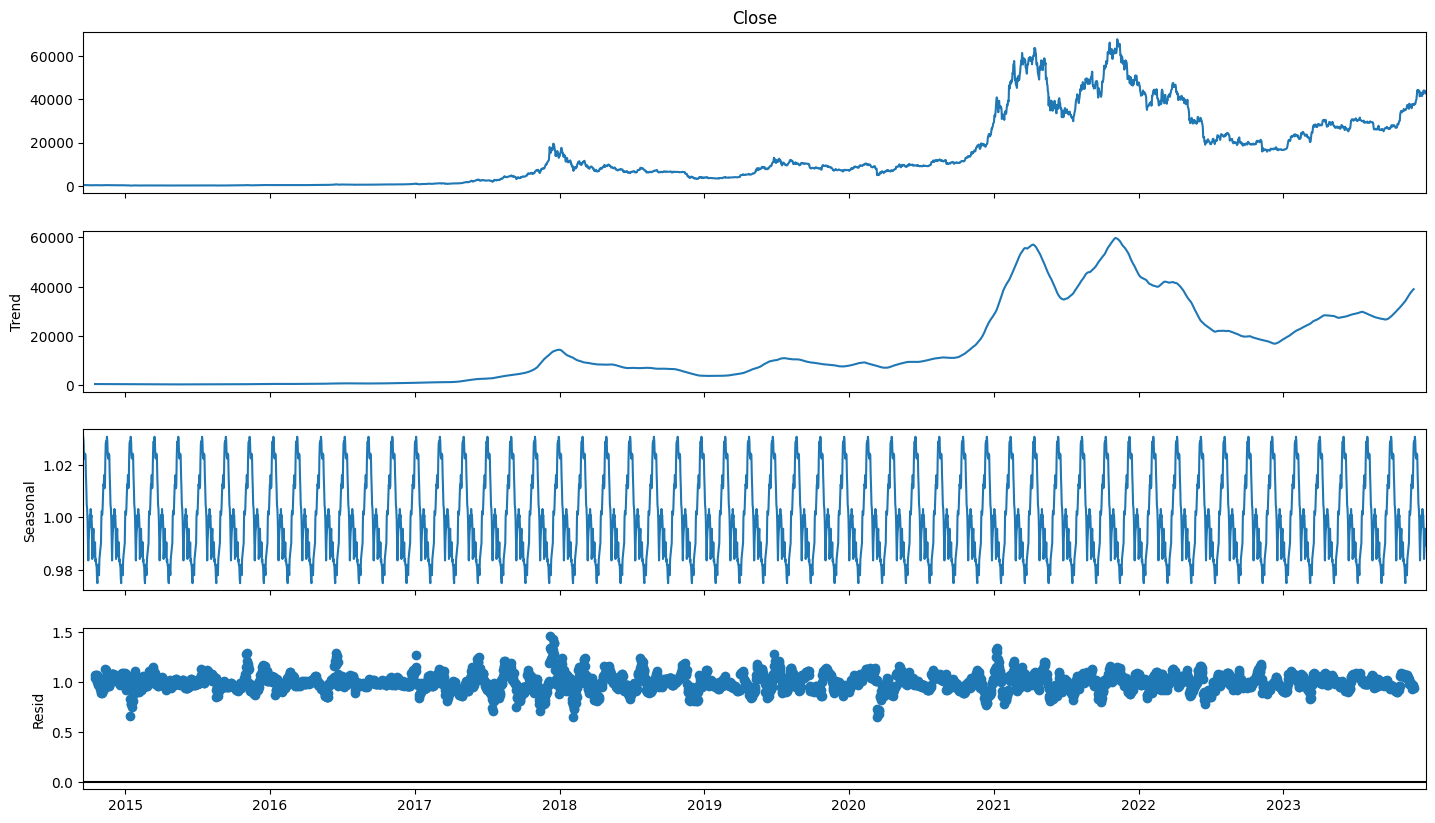

In [8]:
result = seasonal_decompose(df["Close"], model='multiplicative', period = 60)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [9]:
df["Close"].describe()

count     3388.000000
mean     14541.880474
std      16165.456469
min        178.102997
25%        910.545486
50%       8229.853516
75%      23673.097656
max      67566.828125
Name: Close, dtype: float64

In [10]:
X = df["Close"]
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3016.133323, mean2=26067.627625
variance1=13027301.518496, variance2=243928391.918337


# ADFuller Test

In [11]:
def TestStationaryPlot(X):
    rol_mean = X.rolling(window = 30, center = False).mean()
    rol_std = X.rolling(window = 30, center = False).std()
    
    plt.plot(df["Close"], color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

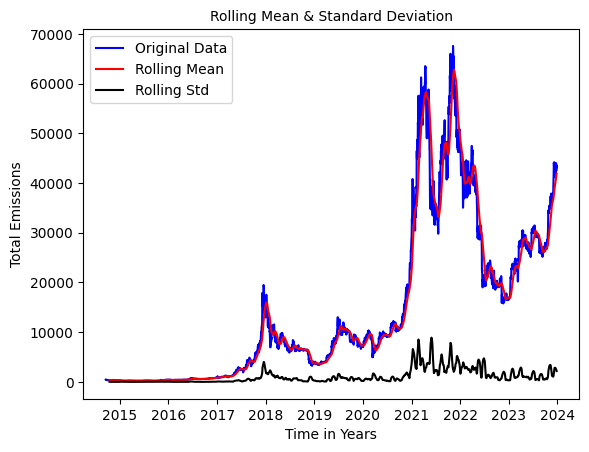

In [12]:
TestStationaryPlot(X)

In [13]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(X, cutoff = 0.01):
    fd_test = adfuller(X, autolag = 'AIC')
    fd_test_output = pd.Series(fd_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    
    for key,value in fd_test[4].items():
        fd_test_output['Critical Value (%s)'%key] = value
    print(fd_test_output)
    
    if fd_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")

In [14]:
TestStationaryAdfuller(X)

Test Statistic                   -1.274780
p-value                           0.640630
Lags Used                        29.000000
Number of Observations Used    3358.000000
Critical Value (1%)              -3.432299
Critical Value (5%)              -2.862401
Critical Value (10%)             -2.567228
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


# Transforming Data into Stationary

# A) Moving Average Method

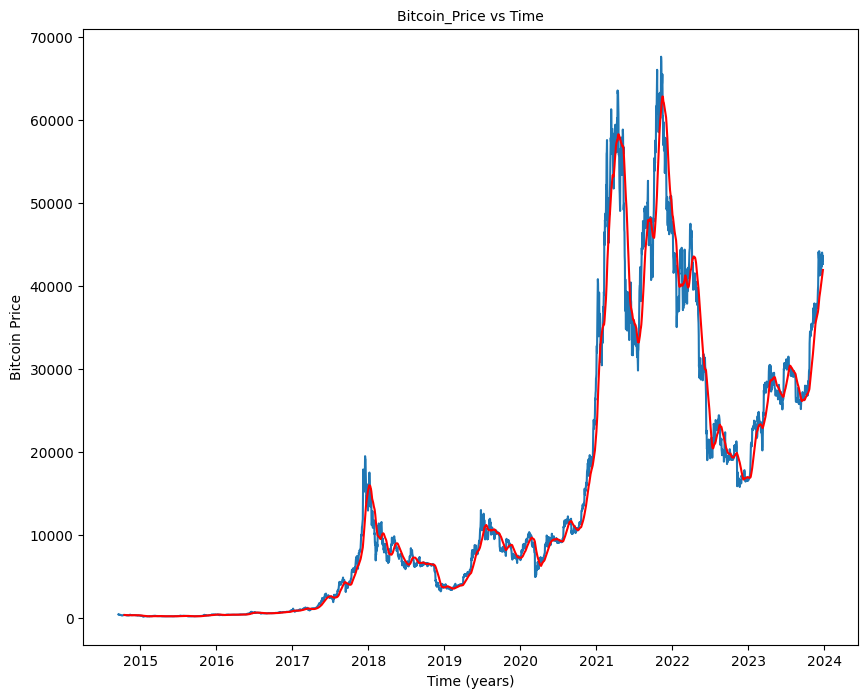

In [15]:
moving_avg = X.rolling(30).mean()
plt.figure(figsize=(10,8))
plt.plot(X)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('Bitcoin Price', fontsize = 10)
plt.title('Bitcoin_Price vs Time', fontsize = 10)
plt.show()

In [16]:
moving_avg_diff = X - moving_avg
moving_avg_diff.head(13)

Date
2014-09-17   NaN
2014-09-18   NaN
2014-09-19   NaN
2014-09-20   NaN
2014-09-21   NaN
2014-09-22   NaN
2014-09-23   NaN
2014-09-24   NaN
2014-09-25   NaN
2014-09-26   NaN
2014-09-27   NaN
2014-09-28   NaN
2014-09-29   NaN
Name: Close, dtype: float64

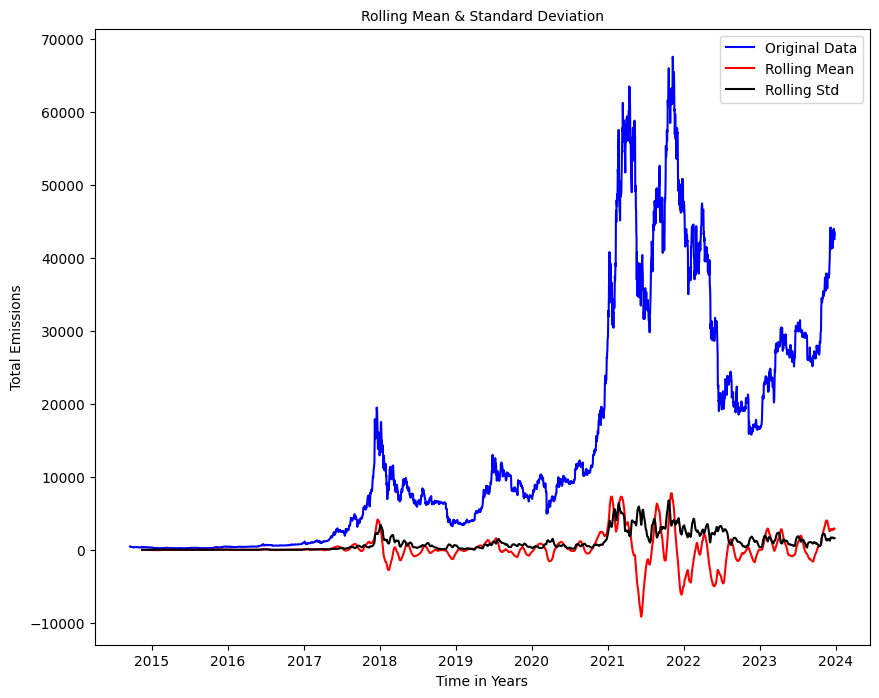

In [17]:
plt.figure(figsize=(10,8))
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [18]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                -6.685868e+00
p-value                        4.227761e-09
Lags Used                      2.900000e+01
Number of Observations Used    3.329000e+03
Critical Value (1%)           -3.432316e+00
Critical Value (5%)           -2.862409e+00
Critical Value (10%)          -2.567232e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


# First Order Differencing

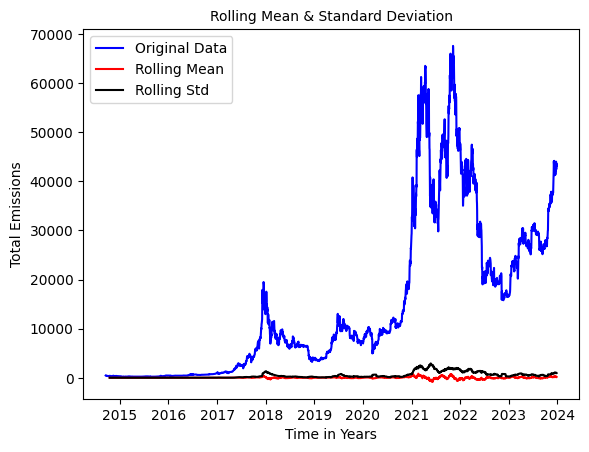

In [19]:
fd_first_difference = X - X.shift(1)  
TestStationaryPlot(fd_first_difference.dropna(inplace=False))

In [20]:
TestStationaryAdfuller(fd_first_difference.dropna(inplace=False))

Test Statistic                -9.701054e+00
p-value                        1.071964e-16
Lags Used                      2.800000e+01
Number of Observations Used    3.358000e+03
Critical Value (1%)           -3.432299e+00
Critical Value (5%)           -2.862401e+00
Critical Value (10%)          -2.567228e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


# Trend & Seasonality Plot

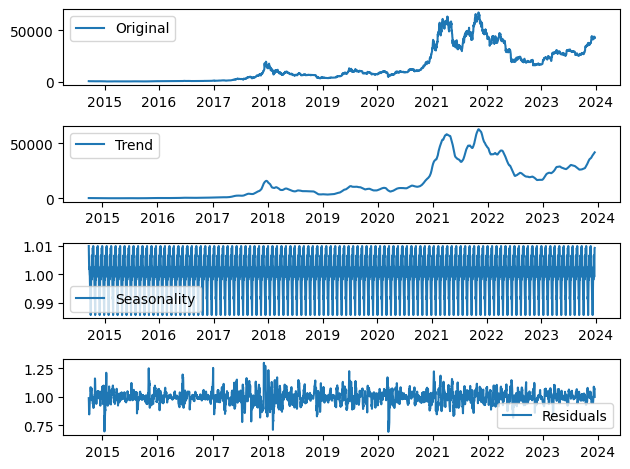

In [21]:
decomposition = seasonal_decompose(X,period=30,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(X, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ACF & PACF Plots

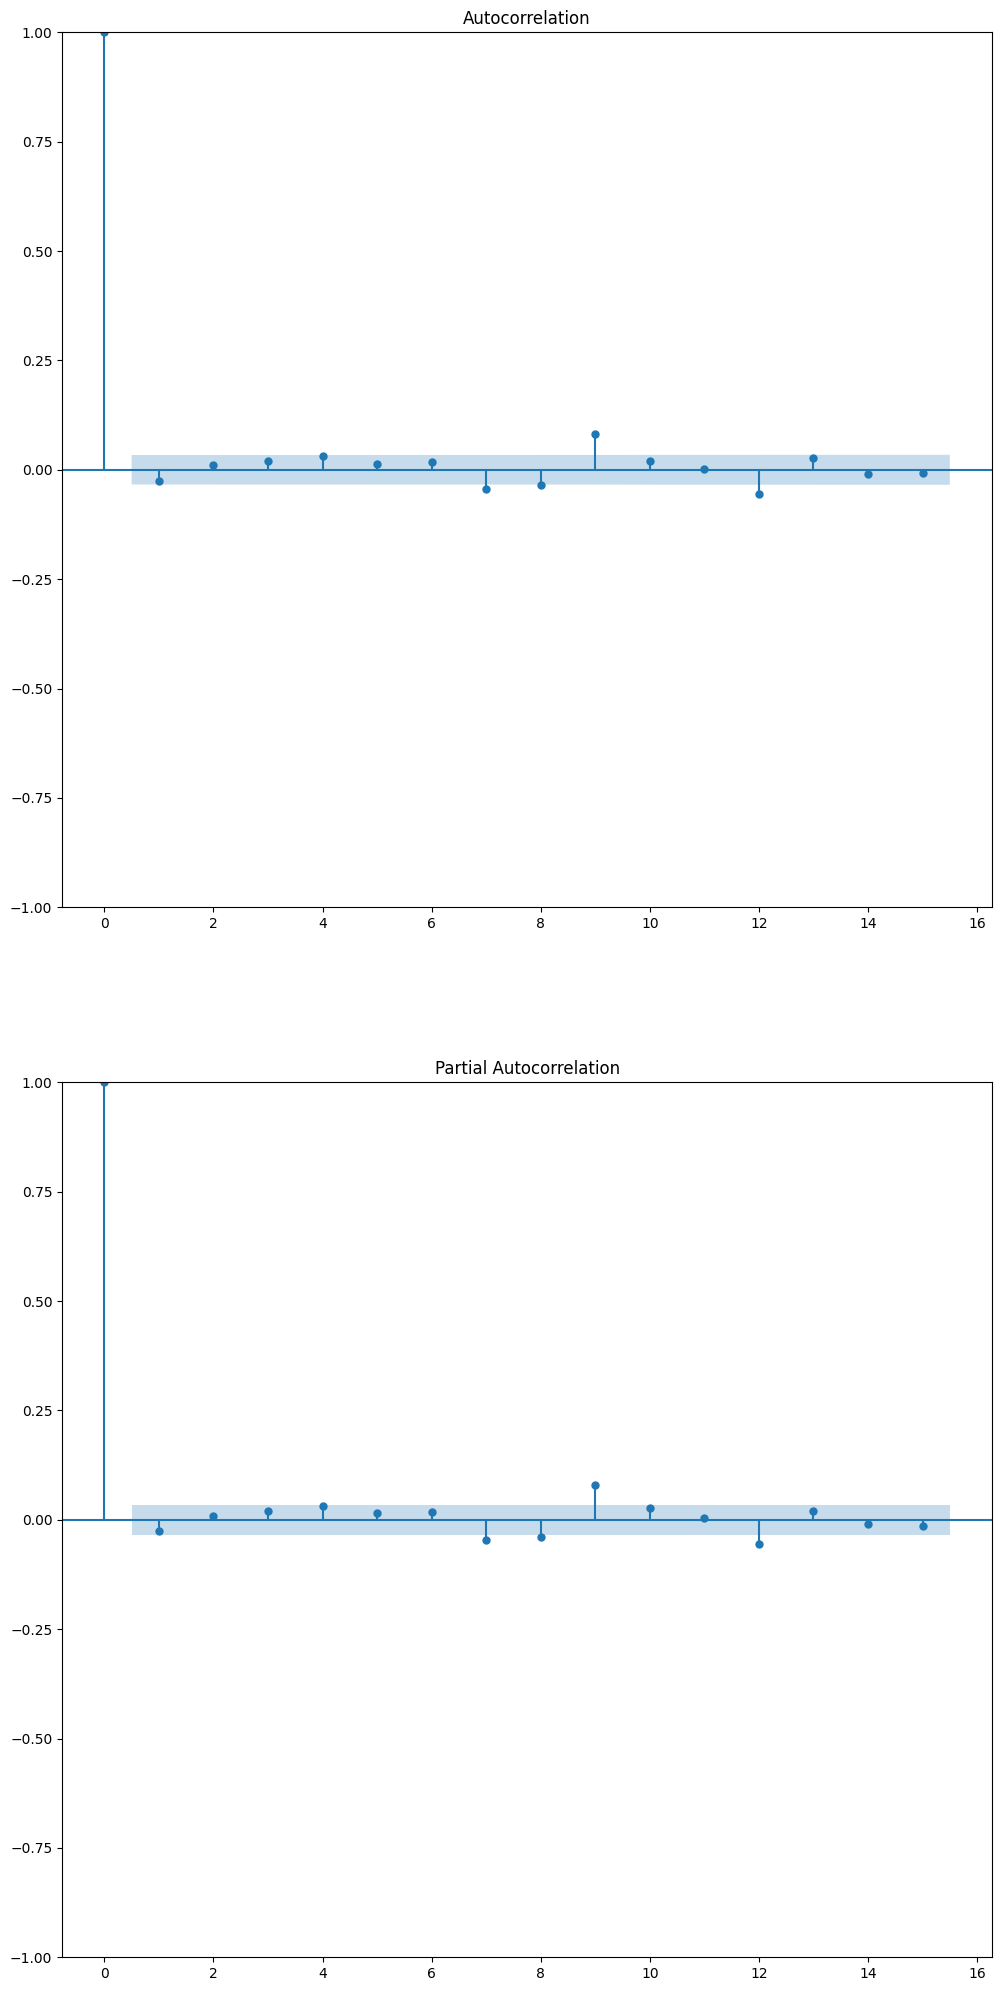

In [22]:
fig = plt.figure(figsize=(12,25))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fd_first_difference.dropna(inplace=False), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fd_first_difference.dropna(inplace=False), lags=15, ax=ax2)

In [23]:
df.drop(["Open" , "High" , "Low","Adj Close" , "Volume"],axis=1,inplace=True)

In [24]:
train = df.iloc[:-356]
test = df.iloc[-356:]

In [25]:
train

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-12-31,16547.496094
2023-01-01,16625.080078
2023-01-02,16688.470703


In [26]:
test

,Close
Date,
2023-01-05,16836.736328
2023-01-06,16951.968750
2023-01-07,16955.078125
2023-01-08,17091.144531
2023-01-09,17196.554688
...,...
2023-12-22,43997.902344
2023-12-23,43739.542969
2023-12-24,43016.117188


## from First order Differencing we consider d=1 & from ACF & PACF plots we consider p=4,8 & q= 4,8 respectively 

# ARIMA Model

# ARIMA (4,1,4)

In [27]:
model_arima = ARIMA(df["Close"],order = (4,1,4))
model_arima = model_arima.fit()
model_arima.summary()

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3388
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -27341.680
Date:                Tue, 26 Dec 2023   AIC                          54701.360
Time:                        15:00:16   BIC                          54756.509
Sample:                    09-17-2014   HQIC                         54721.075
                         - 12-26-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4841      0.010    -48.971      0.000      -0.503      -0.465
ar.L2          0.7124      0.006    116.487      0.000       0.700       0.724
ar.L3         -0.5258      0.006    -89.260      0.000      -0.537      -0.514
ar.L4         -0.9583      0.010    -94.455      0.000      -0.978      -0.938
ma.L1          0.4679      0.012     37.872      0.000       0.444       0.492
ma.L2         -0.6987      0.007   -105.795      0.000      -0.712      -0.686
ma.L3          0.5470      0.007     79.137      0.000       0.533       0.561
ma.L4          0.9384      0.013     73.753      0.000       0.914       0.963
sigma2       6.09e+05   5481.627    111.104      0.000    5.98e+05     6.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             34703.83
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):             386.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2023-01-05    16822.083121
2023-01-06    16884.274014
2023-01-07    16926.909551
2023-01-08    17001.261159
2023-01-09    17065.452558
                  ...     
2023-12-22    43909.103606
2023-12-23    44106.142706
2023-12-24    43616.167684
2023-12-25    43054.244524
2023-12-26    43384.811940
Freq: D, Name: predicted_mean, Length: 356, dtype: float64


In [29]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 'rmse':rmse})

In [30]:
ns_arima_acc = forecast_accuracy(pred_arima.values, test.values)
ns_arima_acc

{'mape': 0.20711503857384836,
 'me': -72.86029320081543,
 'mae': 5921.889588507468,
 'rmse': 7904.8960139793835}

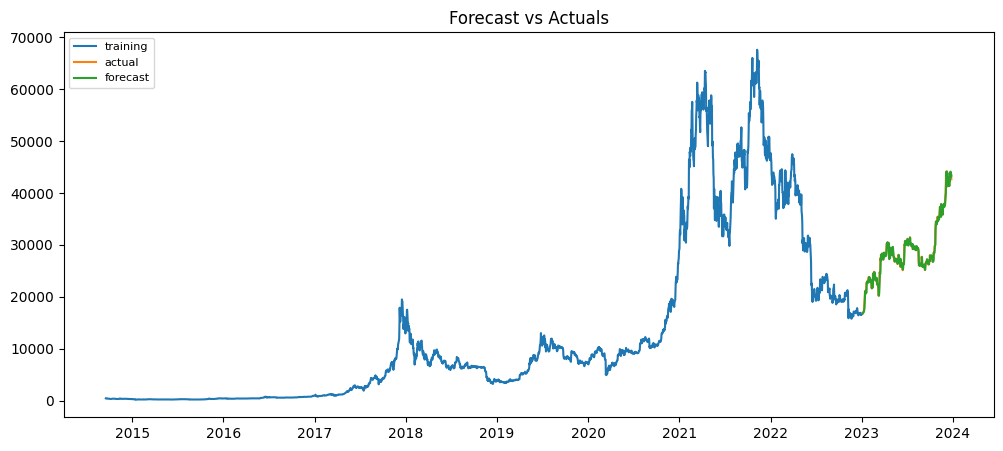

In [31]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

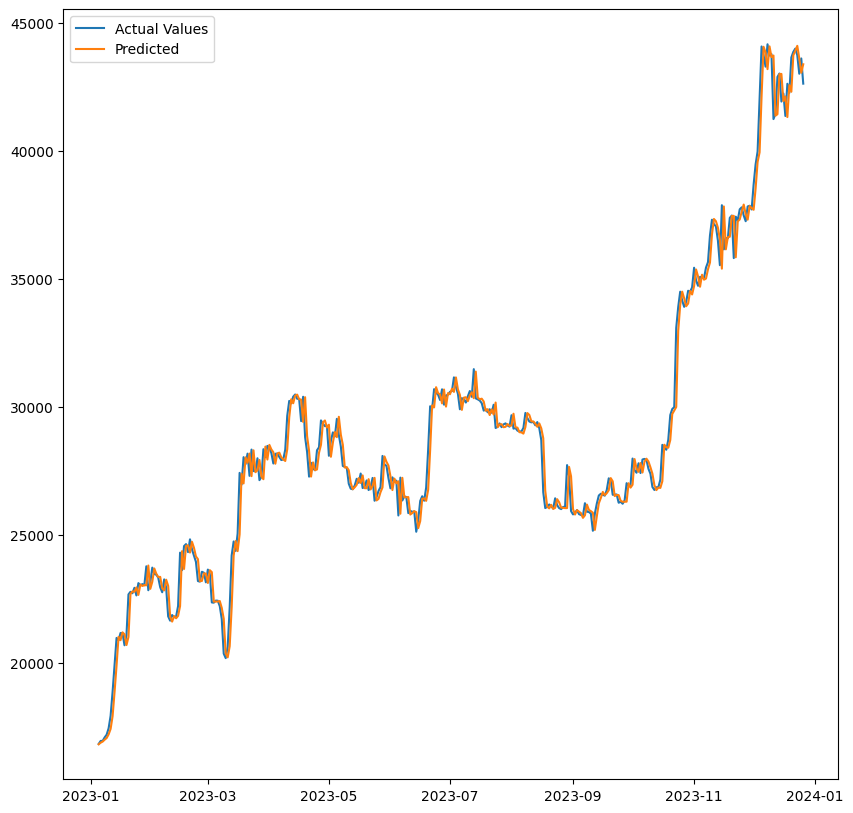

In [32]:
plt.figure(figsize=(10,10))
plt.plot(test , label="Actual Values")
plt.plot(pred_arima , label="Predicted")
plt.legend()

## ARIMA (8,1,8)

In [33]:
model_arima = ARIMA(X,order = (8,1,8))
model_arima = model_arima.fit()
model_arima.summary()

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3388
Model:                 ARIMA(8, 1, 8)   Log Likelihood              -27321.743
Date:                Tue, 26 Dec 2023   AIC                          54677.486
Time:                        15:00:57   BIC                          54781.657
Sample:                    09-17-2014   HQIC                         54714.725
                         - 12-26-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3513      0.203     -1.732      0.083      -0.749       0.046
ar.L2         -0.2212      0.071     -3.102      0.002      -0.361      -0.081
ar.L3         -0.4644      0.067     -6.982      0.000      -0.595      -0.334
ar.L4          0.6638      0.121      5.464      0.000       0.426       0.902
ar.L5          0.3493      0.129      2.700      0.007       0.096       0.603
ar.L6          0.1403      0.063      2.238      0.025       0.017       0.263
ar.L7          0.7401      0.042     17.581      0.000       0.658       0.823
ar.L8          0.0350      0.162      0.217      0.829      -0.282       0.352
ma.L1          0.3286      0.201      1.633      0.102      -0.066       0.723
ma.L2          0.2379      0.062      3.857      0.000       0.117       0.359
ma.L3          0.4785      0.068      7.034      0.000       0.345       0.612
ma.L4         -0.6171      0.121     -5.112      0.000      -0.854      -0.381
ma.L5         -0.2897      0.127     -2.287      0.022      -0.538      -0.041
ma.L6         -0.1444      0.050     -2.871      0.004      -0.243      -0.046
ma.L7         -0.7690      0.042    -18.205      0.000      -0.852      -0.686
ma.L8         -0.0930      0.162     -0.574      0.566      -0.411       0.225
sigma2      6.057e+05   5574.248    108.656      0.000    5.95e+05    6.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             32717.65
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):             349.77   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2023-01-05    16862.149936
2023-01-06    16734.987240
2023-01-07    16858.160623
2023-01-08    17139.426348
2023-01-09    17089.165894
                  ...     
2023-12-22    44058.468613
2023-12-23    44034.836737
2023-12-24    43683.012477
2023-12-25    43278.399929
2023-12-26    43428.824107
Freq: D, Name: predicted_mean, Length: 356, dtype: float64


In [35]:
Ns_arima_acc = forecast_accuracy(pred_arima.values, test.values)
Ns_arima_acc

{'mape': 0.2073121525693186,
 'me': -63.986886741941625,
 'mae': 5926.655871397272,
 'rmse': 7911.3252763393175}

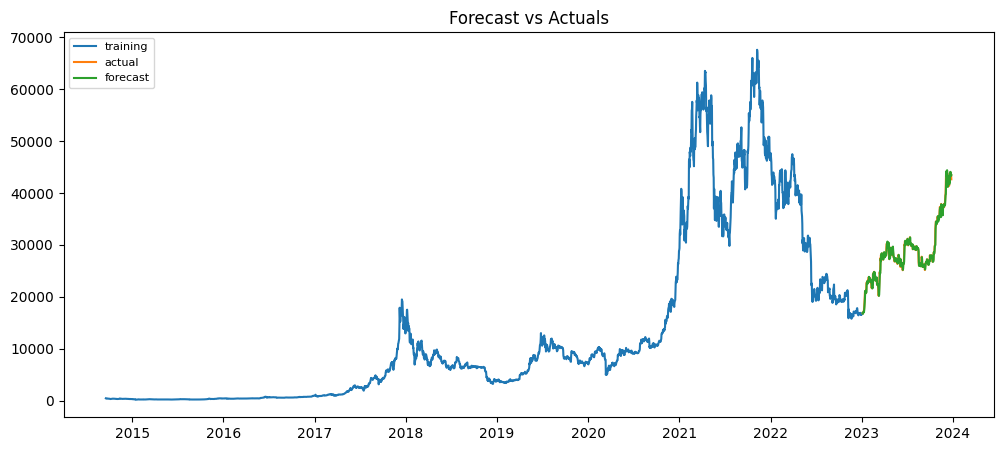

In [36]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Smoothing Technique Methods

In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Simple Exponential Smoothing

In [39]:
SES = SimpleExpSmoothing(train["Close"]).fit(smoothing_level = 0.2)

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [40]:
pred_ses = SES.predict(start = len(train),end = len(train)+len(test)-1)

In [41]:
ns_ses_acc = forecast_accuracy(pred_ses,test.Close)
ns_ses_acc

{'mape': 0.3990201314211955,
 'me': -12088.470068360799,
 'mae': 12088.470068360799,
 'rmse': 13320.9290409919}

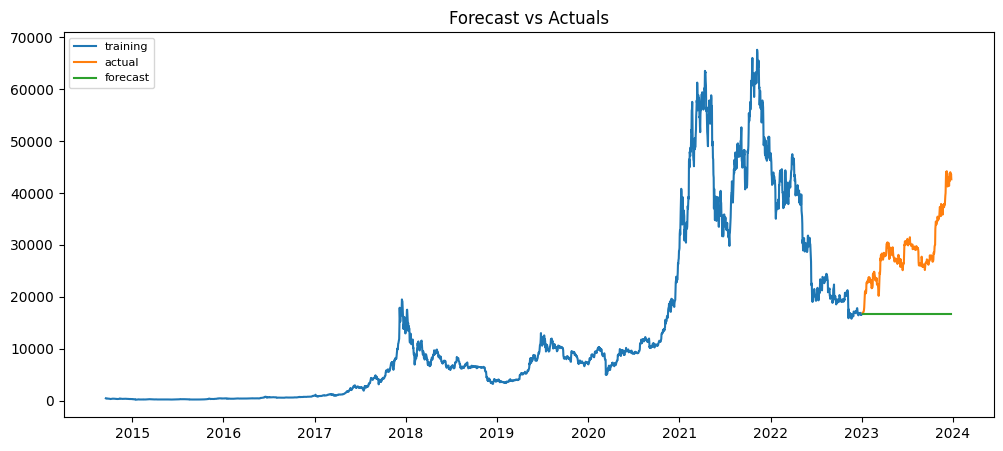

In [42]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Holt's Method

In [43]:
HLT= Holt(train["Close"]).fit(smoothing_level=0.8, smoothing_slope=0.2)

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_7807/2327338740.py:1: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  HLT= Holt(train["Close"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
/home/john/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [44]:
pred_holt = HLT.predict(start = len(train),end = len(train)+len(test)-1)

In [45]:
ns_hlt_acc = forecast_accuracy(pred_holt,test.Close)
ns_hlt_acc

{'mape': 0.21563726074315653,
 'me': -6530.8129168659,
 'mae': 6530.925263542429,
 'rmse': 7495.392215998412}

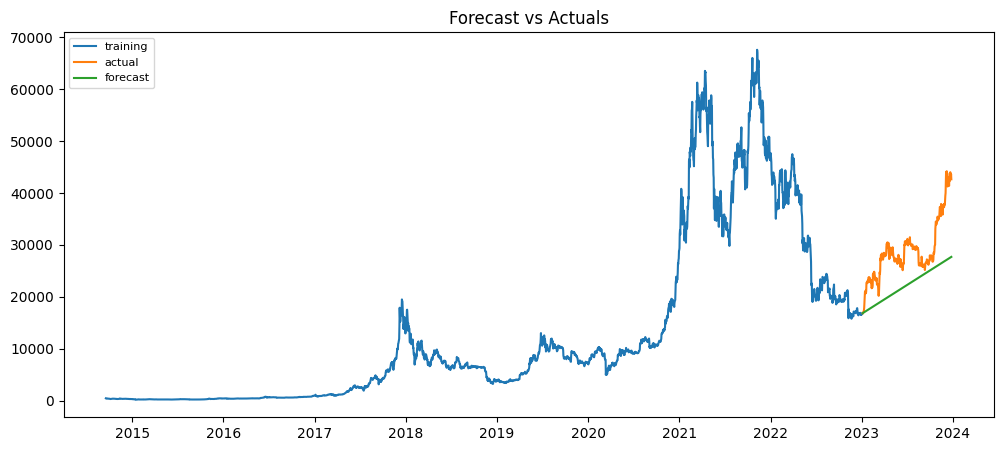

In [46]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Holt-Winter Method¶

In [47]:
HLW = ExponentialSmoothing(train['Close'],seasonal='add',trend='add',seasonal_periods=2).fit()

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [48]:
pred_hlw=HLW.predict(start = len(train),end = len(train)+len(test)-1)

In [49]:
ns_hlw_acc = forecast_accuracy(pred_hlw,test.Close)
ns_hlw_acc

{'mape': 0.3903627778532817,
 'me': -11838.146533668287,
 'mae': 11838.242353985785,
 'rmse': 13072.701402958692}

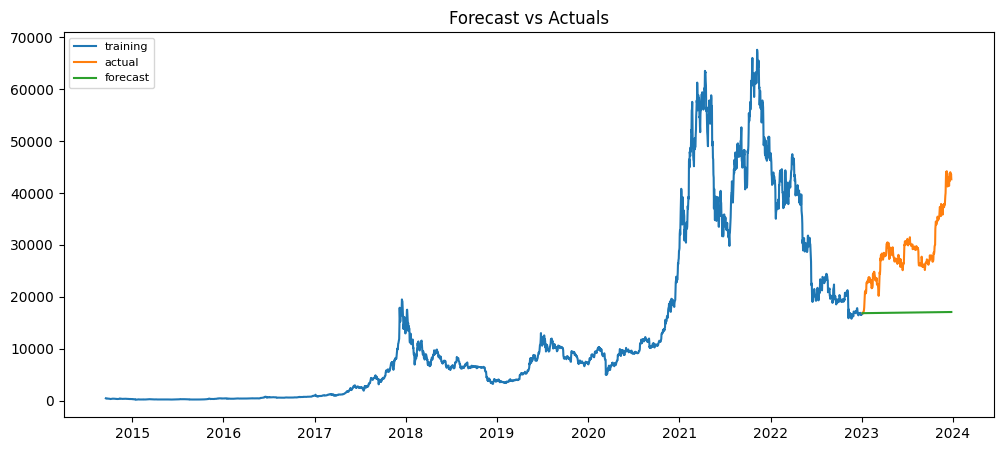

In [50]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hlw, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Modelwise Errors

In [51]:
data = {"MODEL":pd.Series(["ARIMA(4,1,4)","ARIMA(8,1,8)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
3,Holt Method,7495.392216,0.215637,-6530.812917,6530.925264
0,"ARIMA(4,1,4)",7904.896014,0.207115,-72.860293,5921.889589
1,"ARIMA(8,1,8)",7911.325276,0.207312,-63.986887,5926.655871
4,Holt-Winter Method,13072.701403,0.390363,-11838.146534,11838.242354
2,Simple exponential smoothing,13320.929041,0.399020,-12088.470068,12088.470068


In [52]:
tata = {"MODEL":pd.Series(["ARIMA(4,1,4)","ARIMA(8,1,8)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_mape=pd.DataFrame(tata)
table_mape.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
0,"ARIMA(4,1,4)",7904.896014,0.207115,-72.860293,5921.889589
1,"ARIMA(8,1,8)",7911.325276,0.207312,-63.986887,5926.655871
3,Holt Method,7495.392216,0.215637,-6530.812917,6530.925264
4,Holt-Winter Method,13072.701403,0.390363,-11838.146534,11838.242354
2,Simple exponential smoothing,13320.929041,0.399020,-12088.470068,12088.470068


# Final Model

In [53]:
final_arima = ARIMA(df['Close'],order = (4,1,4))
final_arima = final_arima.fit()
final_arima.summary()

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3388
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -27341.680
Date:                Tue, 26 Dec 2023   AIC                          54701.360
Time:                        15:02:44   BIC                          54756.509
Sample:                    09-17-2014   HQIC                         54721.075
                         - 12-26-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4841      0.010    -48.971      0.000      -0.503      -0.465
ar.L2          0.7124      0.006    116.487      0.000       0.700       0.724
ar.L3         -0.5258      0.006    -89.260      0.000      -0.537      -0.514
ar.L4         -0.9583      0.010    -94.455      0.000      -0.978      -0.938
ma.L1          0.4679      0.012     37.872      0.000       0.444       0.492
ma.L2         -0.6987      0.007   -105.795      0.000      -0.712      -0.686
ma.L3          0.5470      0.007     79.137      0.000       0.533       0.561
ma.L4          0.9384      0.013     73.753      0.000       0.914       0.963
sigma2       6.09e+05   5481.627    111.104      0.000    5.98e+05     6.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             34703.83
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):             386.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
final_arima.fittedvalues.tail()

Date
2023-12-20    42103.345176
2023-12-21    43771.392069
2023-12-22    44149.535462
2023-12-23    43988.138131
2023-12-24    43726.771632
dtype: float64

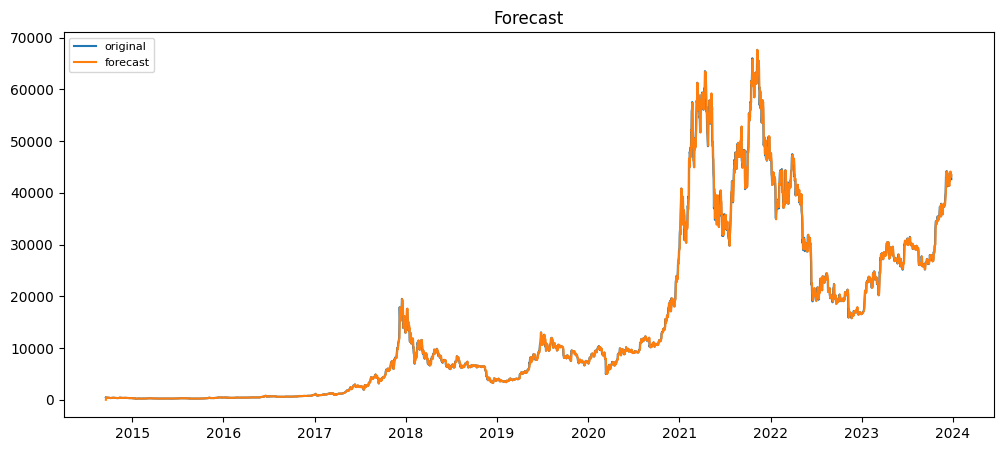

In [54]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X, label='original')

plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [55]:
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,61)]

In [56]:
future_df = pd.DataFrame(index=future_dates[1:] , columns = df.columns)

In [57]:
future_df

,Close
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN
2023-12-30,NaN
2023-12-31,NaN
2024-01-01,NaN
2024-01-02,NaN
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN


In [59]:
x = final_arima.predict(start = 3389, end = 3448, dynamic= True)
# x = final_arima.predict(start = 3385, end = 3450)

/home/john/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [60]:
x = pd.DataFrame(x)

In [61]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-12-28 to 2024-02-25
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [62]:
future_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-12-27 to 2024-02-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   0 non-null      object
dtypes: object(1)
memory usage: 960.0+ bytes


In [63]:
future_df["Close"] = x["predicted_mean"].values


future_df

,Close
2023-12-27,42636.131830
2023-12-28,42824.494582
2023-12-29,42832.092174
2023-12-30,42909.747314
2023-12-31,42880.017757
2024-01-01,42765.237787
2024-01-02,42751.515175
2024-01-03,42617.604479
2024-01-04,42761.489606
2024-01-05,42713.638459


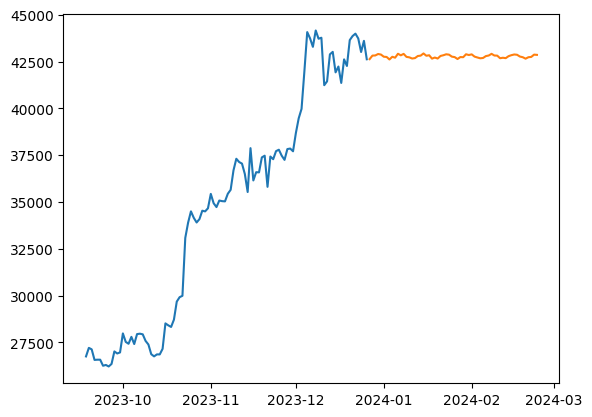

In [64]:
plt.plot(df["Close"][-100:])
plt.plot(future_df["Close"])

In [68]:
import pickle

In [69]:
with open('./bitcoin_prediction.pkl', 'wb') as file:
    pickle.dump(final_arima, file)

In [66]:
future_df[0:5]

,Close
2023-12-27,42636.131830
2023-12-28,42824.494582
2023-12-29,42832.092174
2023-12-30,42909.747314
2023-12-31,42880.017757
